In [1]:
import numpy as np
import torch 
from torch import nn
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.autograd import grad
import os
# from scipy import integrate
# from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib import animation
# from IPython.display import HTML
# plt.rc('savefig', dpi=300)

import numpy as np
# from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import qmsolve
# from qmsolve import Hamiltonian, TwoBosons, SingleParticle, TimeSimulation, init_visualization
from src.nn_fast_new import *
from scipy import sparse
from scipy.sparse import linalg

In [2]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse import kron
from scipy.sparse import eye

In [3]:
def V_noninteract_3(x1, x2, x3, omega2):
    V_trap_1 = 0.5 * omega2 * x1**2
    V_trap_2 = 0.5 * omega2 * x2**2
    V_trap_3 = 0.5 * omega2 * x3**2
    return  V_trap_1 + V_trap_2 + V_trap_3


def V_interact_3(x1, x2, x3, g=1.0, s2=0.1):
    V_soft_contact = 0.5 * g / np.sqrt(2*np.pi*s2) * np.exp(-0.5 * (x1 - x2)**2 / s2) + \
                    0.5 * g / np.sqrt(2*np.pi*s2) * np.exp(-0.5 * (x1 - x3)**2 / s2) + \
                    0.5 * g / np.sqrt(2*np.pi*s2) * np.exp(-0.5 * (x2 - x3)**2 / s2)
#                     0.5 * g / np.sqrt(2*np.pi*s2) * np.exp(-0.5 * (x2 - x1)**2 / s2) + \
#                     0.5 * g / np.sqrt(2*np.pi*s2) * np.exp(-0.5 * (x3 - x1)**2 / s2) + \
#                     0.5 * g / np.sqrt(2*np.pi*s2) * np.exp(-0.5 * (x3 - x2)**2 / s2) 
    return V_soft_contact


def potential_sum_3(g, omega2):
    def _potential_sum3(particles, g, omega2):
        return V_noninteract_3(particles.x1, particles.x2, particles.x3, omega2) +\
                    V_interact_3(particles.x1, particles.x2,particles.x3, g)
    return lambda x: _potential_sum3(x, g, omega2)


def potential_non_interact3(omega2):
    def _potential_non_interact3(particles,omega2):
        return V_noninteract_3(particles.x1, particles.x2, particles.x3, omega2) 
    return lambda x: _potential_non_interact3(x, omega2)


def ground_state_func_3(x, d, omega, m, h):
    a = (omega*m/np.pi/h)**(d/4) * np.exp(-0.5*m *omega* np.einsum("ijkl, ijkl -> ijk", x, x)/h)
    return a


In [4]:
spatial_dim = 1.5
spatial_num = 50

s2 = 0.1
g = 1.0
omega2 = 1.0
omega = np.sqrt(omega2)
m = 1.0
h = qmsolve.hbar
d = 3
T = 1.0
N = 1000

In [5]:
hbar = h
eV = qmsolve.eV

In [6]:
class ThreeParticles(qmsolve.particle_system.particle_system.ParticleSystem):

    def __init__(self, m = qmsolve.m_e, spin = None):
        """
        N: number of grid points
        extent: spacial extent, measured in angstroms
        """
        self.m = m
        self.spin = spin

    def get_observables(self, H):

        if H.spatial_ndim ==1:
            x1 = np.linspace(-H.extent/2, H.extent/2, H.N)
            x2 = np.linspace(-H.extent/2, H.extent/2, H.N)
            x3 = np.linspace(-H.extent/2, H.extent/2, H.N)
            self.x1, self.x2, self.x3 = np.meshgrid(x1,x2,x3)
            H.ndim = 3
            
        elif H.spatial_ndim == 2 or H.spatial_ndim == 3:
            raise NotImplementedError(
                f"Three-particle is not implemented for a 2D/3D two particles")


    def compute_momentum_space(self, H):
        """
        Used for split step method
        """
        if H.spatial_ndim == 1:

            self.p1 = np.fft.fftshift(np.fft.fftfreq(H.N, d = H.dx)) * hbar  * 2*np.pi
            self.p2 = np.fft.fftshift(np.fft.fftfreq(H.N, d = H.dx)) * hbar  * 2*np.pi
            self.p3 = np.fft.fftshift(np.fft.fftfreq(H.N, d = H.dx)) * hbar  * 2*np.pi
            p1, p2, p3 = np.meshgrid(self.p1, self.p2, self.p3)

            self.p2 = (p1**2 + p2**2 + p3**2)

        elif self.H.spatial_ndim == 2 or self.H.spatial_ndim == 3:
            raise NotImplementedError(
                f"split-step isn't implemented for a 2D two particle")



    def get_kinetic_matrix(self, H):

        I = eye(H.N)
        T_ =  diags([-2., 1., 1.], [0,-1, 1] , shape=(H.N, H.N)) *-qmsolve.k/(self.m*H.dx**2)

        if H.spatial_ndim ==1:
            print("1 dim")
            T = (kron(T_, kron(I, I)) + kron(I, kron(T_, I)) + kron(I, kron(I, T_)))
            
            # T =  (kron(T_,I) + kron(I,T_))
        elif H.spatial_ndim ==2:
            raise NotImplementedError(
                f"Three bosons isn't implemented for a 2D two particle")
            # T =  (kron(T_,I,I,I) + kron(I,T_,I,I) + kron(I,I,T_,I) + kron(I,I,I,T_))
        return T
    

In [7]:
from qmsolve.eigenstates import Eigenstates

class ThreeBosons(ThreeParticles):


    def get_eigenstates(self, H, max_states, eigenvalues, eigenvectors):

        eigenvectors  = eigenvectors.T.reshape(( max_states, *[H.N]*H.ndim) )

        # Normalize the eigenvectors
        eigenvectors = eigenvectors/np.sqrt(H.dx**H.ndim)
        

        energies = []
        eigenstates_array = []

        #antisymmetrize eigenvectors:
        # This is made by applying (𝜓(r1 , s1, r2 , s2) + 𝜓(r2 , s2, r1 , s1))/sqrt(2) to each state.
        for i in range(max_states):
            eigenstate_tmp = (eigenvectors[i] + eigenvectors[i].swapaxes(0,1))/np.sqrt(2)

            norm = np.sum(eigenstate_tmp*eigenstate_tmp)*H.dx**H.ndim 

            TOL = 0.02
            
            # for some reason when the eigenstate is degenerated it isn't normalized 
            #print("norm",norm)
            eigenstate_tmp = eigenstate_tmp/np.sqrt(norm)

                 
            if eigenstates_array != []: #check if it's the first eigenstate
                inner_product = np.sum(eigenstates_array[-1]* eigenstate_tmp)*H.dx**H.ndim
                #print("inner_product",inner_product)
            else:
                inner_product = 0


            if np.abs(inner_product) < TOL: # check if is eigenstate_tmp is repeated. (inner_product should be zero)

                eigenstates_array +=  [eigenstate_tmp]
                energies +=  [eigenvalues[i]]
                
        if H.spatial_ndim == 1:
            type = " ThreeIdenticalParticles1D"

        eigenstates = Eigenstates(np.array(energies)/eV, eigenstates_array, H.extent, H.N, type)
        return eigenstates

In [8]:
particles = ThreeBosons()

H_interact = Hamiltonian(particles = particles,
                potential = potential_sum_3(g, omega2),
                spatial_ndim = 1, N = spatial_num, extent = int(2*spatial_dim));

1 dim


In [9]:
class TimeSimulation:
    """
    Class for configuring time dependent simulations.
    """

    def __init__(self, hamiltonian, method = "split-step"):

        self.H = hamiltonian

        implemented_solvers = ('split-step', 'split-step-cupy', 'crank-nicolson', 'crank-nicolson-cupy')

        if method == "split-step":

            if self.H.potential_type == "grid":
                self.method = SplitStep(self)
            else:
                raise NotImplementedError(
                f"split-step can only be used with grid potential_type. Use crank-nicolson instead")

        elif method == "split-step-cupy":
            if self.H.potential_type == "grid":
                self.method = SplitStepCupy(self)
            else:
                raise NotImplementedError(
                f"split-step can only be used with grid potential_type. Use crank-nicolson instead")


        elif method == "crank-nicolson":
            self.method = CrankNicolson(self)
            
        elif method == "crank-nicolson-cupy":
            self.method = CrankNicolsonCupy(self)
        else:
            raise NotImplementedError(
                f"{method} solver has not been implemented. Use one of {implemented_solvers}")



    def run(self, initial_wavefunction, total_time, dt, store_steps = 1):
        """
        """
        self.method.run(initial_wavefunction, total_time, dt, store_steps)

In [10]:
class CrankNicolson(qmsolve.time_dependent_solver.method.Method):
    def __init__(self, simulation):

        self.simulation = simulation
        self.H = simulation.H

        if self.H.potential_type == "matrix":
            self.H.particle_system.get_observables(self.H)

        self.simulation.Vmin = np.amin(self.H.Vgrid)
        self.simulation.Vmax = np.amax(self.H.Vgrid)

    def run(self, initial_wavefunction, total_time, dt, store_steps = 1):

        self.simulation.store_steps = store_steps
        dt_store = total_time/store_steps
        self.simulation.total_time = total_time
        
#         print(total_time, dt)
        Nt = int(np.round(total_time / dt))
        Nt_per_store_step = int(np.round(dt_store / dt))
        self.simulation.Nt_per_store_step = Nt_per_store_step

        #time/dt and dt_store/dt must be integers. Otherwise dt is rounded to match that the Nt_per_store_stepdivisions are integers
        self.simulation.dt = dt_store/Nt_per_store_step
#         print("!!!", self.simulation.H.particle_system)
        
#         if isinstance(self.simulation.H.particle_system ,SingleParticle):
#             Ψ = np.zeros((store_steps + 1, self.H.N **self.H.ndim), dtype = np.complex128)
#             I = sparse.identity(self.H.N **self.H.ndim)
#             Ψ[0] = np.array(initial_wavefunction(self.H.particle_system)).reshape( self.H.N **self.H.ndim)

#         elif isinstance(self.simulation.H.particle_system,TwoParticles):
#             Ψ = np.zeros((store_steps + 1, self.H.N ** 2), dtype = np.complex128)
#             I = sparse.identity(self.H.N ** 2)
#             Ψ[0] = np.array(initial_wavefunction(self.H.particle_system)).reshape(self.H.N**2 )
        if isinstance(self.simulation.H.particle_system, ThreeParticles):
            Ψ = np.zeros((store_steps + 1, self.H.N ** 3), dtype = np.complex128)
            I = sparse.identity(self.H.N ** 3)
            Ψ[0] = np.array(initial_wavefunction(self.H.particle_system)).reshape(self.H.N**3)


        m = self.H.particle_system.m


        BETA = 0.5j*self.simulation.dt/qmsolve.hbar
        
        print(self.H.T.shape, self.H.V.shape)
        H_matrix = self.H.T + self.H.V
        A = I + BETA*H_matrix
        B = I - BETA*H_matrix
        #We are going to solve the equation A*Ψ_{i+1} = B*Ψ_{i} for Ψ_{i+1}

        D = sparse.diags(A.diagonal(0), (0))
        INV_D = sparse.diags(1.0/A.diagonal(0), (0))
        L_PLUS_U = A - D
        
        t0 = time.time()
        bar = progressbar.ProgressBar()
        for i in bar(range(store_steps)):
            tmp = np.copy(Ψ[i])
            for j in range(Nt_per_store_step):
                B_dot_Ψ = B @ tmp
                tmp = linalg.gcrotmk(A, B_dot_Ψ)[0]
                #tmp = jacobi(INV_D, L_PLUS_U, B_dot_Ψ, min_iter=10, max_iter = 50, TOL = 0.00001)
            Ψ[i+1] = tmp
        print("Took", time.time() - t0)

#         if isinstance(self.simulation.H.particle_system ,SingleParticle):
#             self.simulation.Ψ = Ψ.reshape(store_steps + 1, *([self.H.N] *self.H.ndim ))

#         elif isinstance(self.simulation.H.particle_system,TwoParticles):
#             self.simulation.Ψ = Ψ.reshape(store_steps + 1, *([self.H.N] *2 ))
        if isinstance(self.simulation.H.particle_system,ThreeParticles):
            self.simulation.Ψ = Ψ.reshape(store_steps + 1, *([self.H.N] *3 ))

        self.simulation.Ψmax = np.amax(np.abs(Ψ))
        

In [11]:
x, y, z = np.linspace(-spatial_dim, spatial_dim, spatial_num), \
            np.linspace(-spatial_dim, spatial_dim, spatial_num),  \
            np.linspace(-spatial_dim, spatial_dim, spatial_num)
X, Y, Z = np.meshgrid(x, y, z)

pos = np.stack((X, Y, Z), axis=-1) 

Z = ground_state_func_3(pos, d=3, omega=omega, m=m, h=h)


def init_ground_state(particles):
    return Z

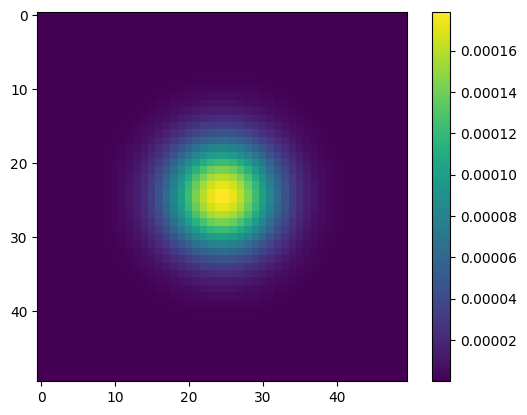

In [12]:
plt.imshow(Z[2, :, :])
plt.colorbar()

In [13]:
import progressbar
total_time = T
sim_inter = TimeSimulation(hamiltonian = H_interact, method = "crank-nicolson")
# sim_inter = TimeSimulation(hamiltonian = H_interact, method = "split-step")
sim_inter.run(init_ground_state, total_time = total_time, dt = total_time/N, 
              store_steps = N)

/tmp/ipykernel_2901893/945667923.py:64: DeprecationWarning: scipy.sparse.linalg.gcrotmk called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  tmp = linalg.gcrotmk(A, B_dot_Ψ)[0]


!!! <__main__.ThreeBosons object at 0x7ff917083520>
(125000, 125000) (125000, 125000)


100% |#######################################################################################################################################################################|


Took 20.375385284423828


In [14]:
dx = 2* spatial_dim / spatial_num

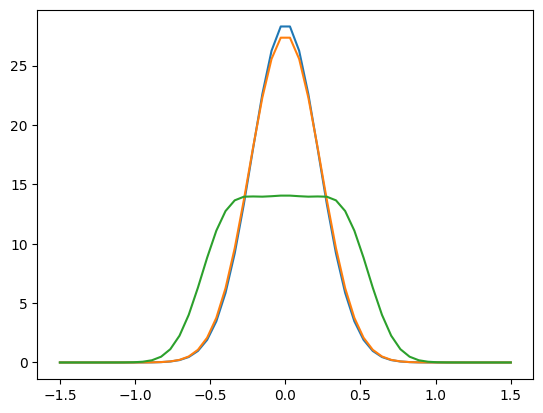

In [15]:
i=0
plt.plot(x, dx * np.abs(np.sum((sim_inter.Ψ[i])*np.conjugate(sim_inter.Ψ[i]), axis=(0,1))))
i=100
plt.plot(x, dx * np.abs(np.sum((sim_inter.Ψ[i])*np.conjugate(sim_inter.Ψ[i]), axis=(0,1))))
i=500
plt.plot(x, dx * np.abs(np.sum((sim_inter.Ψ[i])*np.conjugate(sim_inter.Ψ[i]), axis=(0,1))))
i=900

In [16]:
prob_density_inter = np.abs(sim_inter.Ψ)**2 * dx**3

density_truth_x1 = prob_density_inter.sum(axis=(1, 2)).T / dx
density_truth_x2 = prob_density_inter.sum(axis=(1, 3)).T / dx
density_truth_x3 = prob_density_inter.sum(axis=(2, 3)).T / dx

In [22]:
np.save("wave_func_three_bosons.npy", sim_inter.Ψ)

In [17]:
lb = np.array([-spatial_dim, 0.0])
ub = np.array([spatial_dim, T])

In [18]:
def make_density_plot(p, low_bound=[-2.0, 0.0], up_bound=[2.0, 1.5], title='Plot title', vmin_max = [0, 2]):
    fig, ax = plt.subplots(1, 1) #newfig(1.0, 0.9)
    ax.remove()  
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h_ = ax.imshow(p, cmap='YlGnBu', 
                  extent=[low_bound[1], up_bound[1], low_bound[0], up_bound[0]], 
                  origin='lower', aspect='auto', vmin=vmin_max[0], vmax=vmin_max[1])
    # h_.clim(0, 1.5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h_, cax=cax)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    # leg = ax.legend(frameon=False, loc = 'best')
#     plt.setp(leg.get_texts(), color='w')
    ax.set_title(title, fontsize = 12);
    plt.show();

In [19]:
v_max_ = round(max(np.max(density_truth_x1.reshape(-1)), 
                   np.max(density_truth_x2.reshape(-1)),
                   np.max(density_truth_x3.reshape(-1))) + 0.1, 1)

1.0 1000 50


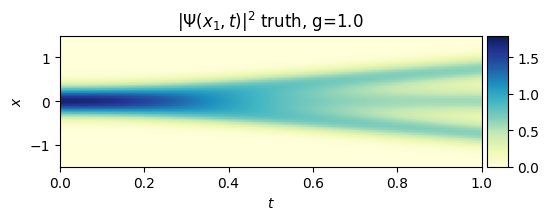

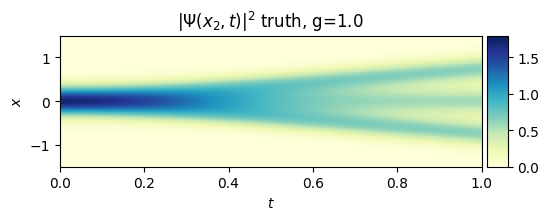

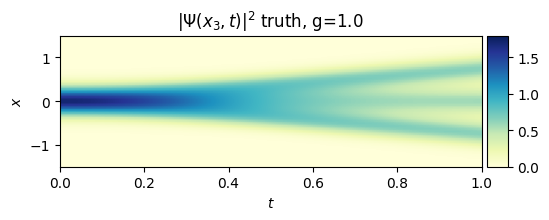

In [20]:
print(T, N, spatial_num)
make_density_plot(density_truth_x1, low_bound=lb, up_bound=ub,
                      title='$|\Psi(x_1, t)|^2$ truth, g={}'.format(g), vmin_max = [0, v_max_])
make_density_plot(density_truth_x2, low_bound=lb, up_bound=ub,
                      title='$|\Psi(x_2, t)|^2$ truth, g={}'.format(g), vmin_max = [0, v_max_])
make_density_plot(density_truth_x3, low_bound=lb, up_bound=ub,
                      title='$|\Psi(x_3, t)|^2$ truth, g={}'.format(g), vmin_max = [0, v_max_])
